In [149]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# 1. Adathalmaz előkészítése

Olvasd be a movies_prep és a ratings_sample csv fájlokat. Előbbi az egyes filmek kategóriáját tartalmazza, utóbbi pedig a filmekre vonatkozó felhasználói értékeléseket.

In [150]:
movies = pd.read_csv("movies_prep.csv")
ratings = pd.read_csv("ratings_sample.csv")

Normalizáld a felhasználók egyes értékeléseit az adott felhasználó átlagos értékelésével (adott felhasználó minden értékeléséből kivonod, hogy az összes általa értékelt filmen mi volt az átlagos értékelése) - megszokott értékelési tendenciájához képest jobban / kevésbé kedveli.

In [151]:
user_avg_ratings = (
    ratings.groupby("userId")["rating"]
    .mean()
    .reset_index()
    .rename(columns={"rating": "user_avg_rating"})
)
ratings = pd.merge(
    ratings, user_avg_ratings, on="userId", how="left", validate="many_to_many"
)
ratings["rating_norm"] = ratings["rating"] - ratings["user_avg_rating"]
ratings = ratings.drop(columns=["user_avg_rating"])
ratings

userId  movieId  rating   timestamp  rating_norm
0        123759     3243     3.0  1017030084    -0.701149
1        104903      594     2.0  1082736879    -1.521739
2         14310     2953     4.0   992503206     0.333333
3         62120     3917     1.0  1460077438    -1.457447
4          9650    98809     1.0  1500832106    -2.696429
...         ...      ...     ...         ...          ...
2999995  114722      186     4.0   946040571     0.873016
2999996   60260     1907     5.0   945109248     0.812500
2999997  135481     2942     1.5  1238976761    -0.166667
2999998   36671     2617     3.5  1541880180     0.445946
2999999   91176      708     0.5  1538103704    -2.582090

[3000000 rows x 5 columns]

A filmkategóriáknál (genre_) a 0 értékeket helyettesítsd nan értékkel majd szorozd rá az adott film normalizált értékelését (rating). Ezután állítsd elő, hogy az egyes felhasználók az egyes kategóriákat átlagosan mennyire szeretik, hogy a klaszterező algoritmus számára megfelelő formába kerüljön.

In [152]:
genre_columns = [col for col in movies.columns if "genre_" in col]
movies[genre_columns] = movies[genre_columns].replace({0: np.nan})
ratings = pd.merge(
    ratings,
    movies[["movieId"] + genre_columns],
    on="movieId",
    how="left",
    validate="many_to_many",
)
ratings[genre_columns] = ratings[genre_columns].mul(ratings["rating_norm"], axis=0)
user_genre_avg = ratings.groupby("userId")[genre_columns].mean()
user_genre_avg

genre_Adventure  genre_Animation  genre_Children  genre_Comedy  \
userId                                                                   
1          2.222222e-01              NaN             NaN  7.222222e-01   
2          3.942857e-01         0.680000        0.930000 -6.950000e-01   
3          6.506239e-02         0.212121       -0.037879 -2.045455e-01   
4         -3.407258e-01         0.453917        0.513441  5.342742e-01   
5         -1.333333e-01         0.266667        0.266667 -3.047619e-01   
...                 ...              ...             ...           ...   
162537    -5.000000e-01              NaN        1.000000  0.000000e+00   
162538    -1.153846e+00              NaN             NaN -1.098901e-02   
162539     2.960595e-16         0.666667        0.666667  2.960595e-16   
162540     7.727273e-01         0.772727        0.772727 -2.272727e-01   
162541     3.000000e-01         0.800000        0.800000  4.875000e-01   

        genre_Fantasy  genre_Romance  genre_Drama  genre_Action  genre_Crime  \
userId                                                                         
1            0.222222       1.222222     0.007937           NaN    -0.277778   
2            0.180000      -1.570000     0.121176     -0.257500     0.680000   
3           -0.037879      -0.287879     0.212121     -0.166257     0.327506   
4           -1.003226       0.263441     0.696774     -0.181004     0.596774   
5           -0.400000      -0.533333     0.266667     -0.400000          NaN   
...               ...            ...          ...           ...          ...   
162537       0.000000      -0.200000     0.000000     -0.500000          NaN   
162538      -0.153846      -0.403846     0.446154      0.246154     1.012821   
162539       0.666667            NaN     0.666667     -0.666667     0.666667   
162540      -0.560606       0.372727     0.439394      0.272727    -2.227273   
162541       1.383333       0.550000    -0.033333     -0.592857          NaN   

        genre_Thriller  genre_Horror  genre_Mystery  genre_Sci-Fi  genre_IMAX  \
userId                                                                          
1            -0.277778           NaN            NaN           NaN         NaN   
2             0.480000      0.180000       0.430000      0.680000    0.680000   
3            -0.047138     -0.537879       0.524621     -0.172494   -0.232323   
4            -0.153226           NaN       0.096774     -0.903226   -1.203226   
5            -0.400000      0.266667       1.266667      0.266667    0.266667   
...                ...           ...            ...           ...         ...   
162537        1.000000      0.000000       1.000000     -1.000000         NaN   
162538        0.096154           NaN       0.846154     -0.320513   -0.153846   
162539        0.333333           NaN       0.666667     -0.333333         NaN   
162540        0.772727      0.772727       0.772727      0.272727    0.272727   
162541        0.050000     -0.700000       1.550000     -0.878571   -0.950000   

        genre_Documentary  genre_War  genre_Musical  genre_Western  \
userId                                                               
1                     NaN  -0.027778            NaN            NaN   
2                     NaN   1.180000       0.680000            NaN   
3                     NaN  -0.087879            NaN            NaN   
4                     NaN   0.096774       0.346774       0.096774   
5                     NaN        NaN       0.266667      -0.733333   
...                   ...        ...            ...            ...   
162537                NaN        NaN            NaN            NaN   
162538                NaN   0.346154            NaN            NaN   
162539                NaN  -0.333333            NaN            NaN   
162540                NaN   1.772727       1.272727            NaN   
162541                NaN   1.050000            NaN       0.050000   

        genre_Film-Noir  
userId       

# 2. K-Means klaszterezés

Keresd meg hány klasztert kellene létrehozni a K-Means algoritmussal a felhasználókból (random_state = 42 értékkel).

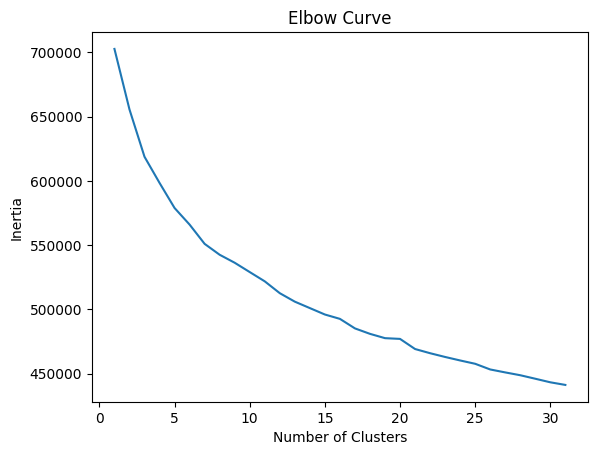

In [153]:
MAX_CLUSTERS = 32

# create a list of inertia values for each k
inertias = []
for k in range(1, MAX_CLUSTERS):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(user_genre_avg.fillna(0))
    inertias.append(kmeans.inertia_)

# plot the elbow curve
plt.plot(range(1, MAX_CLUSTERS), inertias)
plt.title("Elbow Curve")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

Ezután végezd el a klaszterezést és vond le a következtetést, hogy melyik klaszternek melyik a 3 legjobban és 3 legkevésbé kedvelt filmkategóriája. Melyik kategória befolyásolja legjobban a klaszterezés eredményét?

In [154]:
N_CLUSTERS = 5
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init="auto")
user_genre_avg["cluster"] = kmeans.fit_predict(user_genre_avg.fillna(0))
user_genre_cluster_avg = user_genre_avg.groupby("cluster").mean()

top3_genres = user_genre_cluster_avg[genre_columns].apply(
    lambda x: x.nlargest(3).index.tolist(), axis=1
)
bottom3_genres = user_genre_cluster_avg[genre_columns].apply(
    lambda x: x.nsmallest(3).index.tolist(), axis=1
)

top3_df = pd.DataFrame(top3_genres.tolist(), columns=["top1", "top2", "top3"])
bottom3_df = pd.DataFrame(
    bottom3_genres.tolist(), columns=["bottom1", "bottom2", "bottom3"]
)
result_df = pd.concat([top3_df, bottom3_df], axis=1)

result_df

top1             top2               top3         bottom1  \
0  genre_Animation    genre_Musical     genre_Children     genre_Crime   
1  genre_Film-Noir    genre_Mystery        genre_Crime   genre_Romance   
2  genre_Film-Noir        genre_War  genre_Documentary    genre_Sci-Fi   
3        genre_War  genre_Film-Noir  genre_Documentary    genre_Horror   
4  genre_Film-Noir        genre_War        genre_Crime  genre_Children   

           bottom2        bottom3  
0   genre_Thriller  genre_Mystery  
1     genre_Comedy  genre_Musical  
2  genre_Adventure   genre_Action  
3   genre_Thriller   genre_Sci-Fi  
4  genre_Animation  genre_Musical

# 3. Hierarchikus klaszterezés

Határozd meg, hogy a felhasználói értékelések szerint melyik filmkategória melyikhez hasonló és a kategóriák hány csoportba kerülnek besorolásra (linkage = 'complete'). A Documentary kategória kedvelőinek ezalapján milyen további filmkategóriát javasolnál, ami várhatóan tetszene nekik?

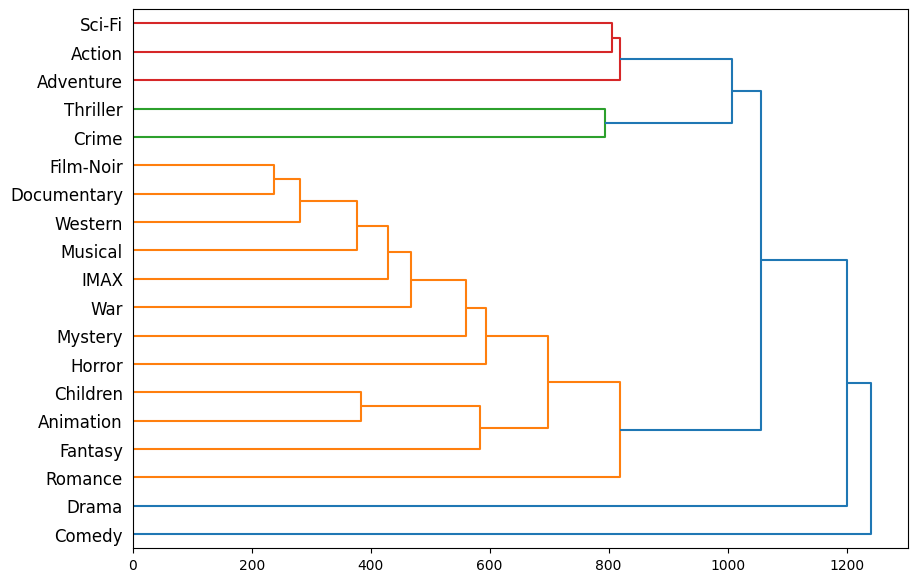

In [155]:
linkage_matrix = sch.linkage(ratings[genre_columns].T.fillna(0), method="complete")
plt.figure(figsize=(10, 7))
sch.dendrogram(
    linkage_matrix, labels=[genre[6:] for genre in genre_columns], orientation="right"
)
plt.show()

Javasolj egy általad választott tetszőleges felhasználó számára az előző és a mostani feladat klaszterezése alapján egy olyan filmet, amilyen kategóriából még nem látott és valószínűleg tetszene neki.

In [156]:
USER_ID = 1
user_genres = (
    ratings.loc[ratings["userId"] == USER_ID, genre_columns]
    .mean()
    .sort_values(ascending=False)
    .dropna()
    .index.tolist()
)

CLUSTER = user_genre_avg["cluster"][USER_ID]
genres_for_cluster = (
    user_genre_cluster_avg[genre_columns]
    .loc[CLUSTER]
    .sort_values(ascending=False)
    .index.tolist()
)

genres_to_recommend = [
    genre for genre in genres_for_cluster if genre not in user_genres
]
GENRE = genres_to_recommend[0]

merged = ratings.merge(
    user_genre_avg[["cluster"]], left_on="userId", right_index=True, how="left"
)
movies_to_recommend = (
    merged[(merged["cluster"] == CLUSTER) & ~merged[GENRE].isna()]
    .groupby("movieId")["rating"]
    .count()
    .sort_values(ascending=False)
    .index.tolist()
)
MOVIE = movies["title"][movies_to_recommend[0]]

MOVIE

'Jumanji (1995)'